# Monte Carlo Project

## Iacob Jessica, Mourre Grégoire

In this Jupter file, we will implement the different methods presented and described in https://github.com/gregoiremrr/Monte-Carlo-for-American-Options.


In [508]:
import numpy as np
from numpy.random import default_rng
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from tqdm import tqdm

# Methods for the lower bound

In [509]:
n = 10000
m = 12
seed = 0
rng = default_rng(seed=seed)

r, sigma, x, K, T = 0.06, .4, 80, 100, 0.5
dt = T/m
t_index = np.linspace(start=0, stop=T, num=m+1).reshape(-1,1)

def g(x,t=0):
    return np.exp(-r*t*dt) * np.maximum(K-x,0)

def phi(x):
    # Canonical basis
    #return np.array([1, x, x**2, x**3], dtype=object)
    #return np.array([1, x, x**2, x**3, g(x)], dtype=object)
    #return np.array([1, x, x**2, x**3, x**4, g(x)], dtype=object)
    #return np.array([1, x, x**2, x**3, g(x), g(x)**2], dtype=object)
    return np.array([1, x, x**2, x**3, g(x), g(x)**2, g(x)**3], dtype=object)
    # Legendre's basis
    #return np.array([1, x, (3*x**2-1)/2, (5*x**3-3*x)/2], dtype=object)
    #return np.array([1, x, (3*x**2-1)/2, (5*x**3-3*x)/2, g(x)], dtype=object)
    #return np.array([1, x, (3*x**2-1)/2, (5*x**3-3*x)/2, (35*x**4-30*x**2+3)/8, g(x)], dtype=object)
    #return np.array([1, x, (3*x**2-1)/2, (5*x**3-3*x)/2, g(x), g(x)**2], dtype=object)
    #return np.array([1, x, (3*x**2-1)/2, (5*x**3-3*x)/2, g(x), g(x)**2, g(x)**3], dtype=object)
    # Hermite's basis
    #return np.array([1, x, x**2-1, x**3-3*x], dtype=object)
    #return np.array([1, x, x**2-1, x**3-3*x, g(x)], dtype=object)
    #return np.array([1, x, x**2-1, x**3-3*x, x**4-6*x**2+3, g(x)], dtype=object)
    #return np.array([1, x, x**2-1, x**3-3*x, g(x), g(x)**2], dtype=object)
    #return np.array([1, x, x**2-1, x**3-3*x, g(x), g(x)**2, g(x)**3], dtype=object)
    # Laguerre's basis
    #return np.array([1, 1-x, (x**2-4*x+2)/2, (-x**3+9*x**2-18*x+6)/6], dtype=object)
    #return np.array([1, 1-x, (x**2-4*x+2)/2, (-x**3+9*x**2-18*x+6)/6, g(x)], dtype=object)
    #return np.array([1, 1-x, (x**2-4*x+2)/2, (-x**3+9*x**2-18*x+6)/6, (x**4-16*x**3+72*x**2-96*x+24)/24, g(x)], dtype=object)
    #return np.array([1, 1-x, (x**2-4*x+2)/2, (-x**3+9*x**2-18*x+6)/6, g(x), g(x)**2], dtype=object)
    #return np.array([1, 1-x, (x**2-4*x+2)/2, (-x**3+9*x**2-18*x+6)/6, g(x), g(x)**2, g(x)**3], dtype=object)
l = len(phi(0))

def reg(x, *alphas):
    alpha = np.array(alphas)
    return np.sum(alpha * phi(x))

# Tsitsiklis & Van Roy's algorithm

In [510]:
rng = default_rng(seed=seed)

# Step 1
B = rng.normal(size=m*n).reshape(m,n)
W = np.concatenate([[np.zeros(n)],np.cumsum(B * np.sqrt(dt), axis=0)])
X = x * np.exp((r-sigma**2/2) * t_index + sigma * W)


# Step 2
V = np.zeros(n*(m+1)).reshape(m+1,n)
V[-1,:] = g(X[-1,:],m)

# Step 3
alpha0 = np.zeros(l)
for i in range(m-1, 0, -1):
    alpha_star = curve_fit(reg, X[i,:], V[i+1,:], p0=alpha0)[0]
    _1 = g(X[i,:],i)
    _2 = reg(X[i,:], alpha_star)
    V[i,:] = _1 * (_1 >= _2) + _2 * (_1 < _2)

# Step 4
_1 = g(x)
_2 = np.mean(V[1,:])
V0 = _1 * (_1 >= _2) + _2 * (_1 < _2)

print("Estimator:", V0)

Estimator: 21.531342843544135


# Longstaff and Schwartz's algorithm
Approximation of the Value Functions (Steps 2 to 4 in Longstaff & Schwartz's algorithm)

In [511]:
rng = default_rng(seed=seed)

# Step 2
V2 = np.zeros(n*(m+1)).reshape((m+1),n)
V2[-1,:] = g(X[-1,:],m)

alpha_tau = np.zeros(l*(m+1)).reshape((m+1),l)

# Step 3
alpha0 = np.zeros(l)
for i in range(m-1, 0, -1):
    alpha_tau[i,:] = curve_fit(reg, X[i,:], V2[i+1,:], p0=alpha0)[0]
    _1 = g(X[i,:],i)
    _2 = reg(X[i,:], alpha_tau[i,:])
    V2[i,:] = _1 * (_1 >= _2) + V2[(i+1),:] * (_1 < _2)

# Step 4 (not used)
_1 = g(x)
_2 = np.mean(V2[1,:])
V02 = np.mean(_1 * (_1 >= _2) + V2[1,:] * (_1 < _2))

Longstaff & Schwartz's algorithm (Step 5)

In [512]:
rng = default_rng(seed=seed)

# Step 5
B2 = rng.normal(size=m*n).reshape(m,n)
W2 = np.concatenate([[np.zeros(n)],np.cumsum(B2 * np.sqrt(dt), axis=0)])
X2 = x * np.exp((r-sigma**2/2) * t_index + sigma * W2)

V3 = np.zeros(n*(m+1)).reshape((m+1),n)
V3[-1,:] = g(X2[-1,:],m)

for i in range(m-1, 0, -1):
    _1 = g(X2[i,:],i)
    _2 = reg(X2[i,:], alpha_tau[i,:])
    V3[i,:] = _1 * (_1 >= _2) + V3[(i+1),:] * (_1 < _2)

_1 = g(x)
_2 = np.mean(V3[1,:])
V03_ = _1 * (_1 >= _2) + V3[1,:] * (_1 < _2)

V03 = np.mean(V03_)
std = np.std(V03_)
conv_interval = V03 + np.array([-1,1]) * 1.96 * std / np.sqrt(n)
final_lowerbound = conv_interval[0]

print("Estimator:", V03)
print("Standard deviation:", std / np.sqrt(n))
print("Condidence interval 95%:", conv_interval)
print("Error:", 100 * 1.96 * std / (V03 * np.sqrt(n)), "%")

Estimator: 21.531230445278087
Standard deviation: 0.1172144816938878
Condidence interval 95%: [21.30149006 21.76097083]
Error: 1.0670100099662598 %


# Martingales from Approximate Value Functions

In [513]:
rng = default_rng(seed=seed)

# One trajectory (just to get the idea of the true method)

n2 = 1000

B_upperbound = rng.normal(size=m)
W_upperbound = np.concatenate([[0],np.cumsum(B_upperbound * np.sqrt(dt), axis=0)])
X_upperbound = x * np.exp((r-sigma**2/2) * t_index.ravel() + sigma * W_upperbound)

Normal = rng.normal(size=m*n2).reshape(m,n2)
M = np.zeros(m+1)
Mi = 0

for i in range(1, m):
    V_upperbound = max(g(X_upperbound[i],i), reg(X_upperbound[i], alpha_tau[i,:]))
    X_next = X_upperbound[i-1] * np.exp((r-sigma**2/2) * dt + sigma * np.sqrt(dt) * Normal[i-1,:])
    V_Ynext = np.maximum(g(X_next,i), reg(X_next, alpha_tau[i,:]))
    delta = V_upperbound - np.mean(V_Ynext)
    Mi += delta
    M[i] = Mi

X_next = X_upperbound[-2] * np.exp((r-sigma**2/2) * dt + sigma * np.sqrt(dt) * Normal[-1,:])
delta = g(X_upperbound[-1],m) - np.mean(g(X_next,m))
Mi += delta
M[-1] = Mi

V0_upperbound = np.max(g(X_upperbound,np.arange(0,m+1)) - M)
print(V0_upperbound)

21.269277564786055


In [514]:
rng = default_rng(seed=seed)

# Monte-Carlo method for n trajectories

n2 = 1000

Normal = rng.normal(size=m*n*n2).reshape(m,n2,n)
M = np.zeros(n*(m+1)).reshape(m+1,n)
Mi = np.zeros(n)

for i in tqdm(range(1, m)):
    V_upperbound = np.maximum(g(X2[i,:],i), reg(X2[i,:], alpha_tau[i,:]))
    X_next = X2[i-1] * np.exp((r-sigma**2/2) * dt + sigma * np.sqrt(dt) * Normal[i-1,:,:])
    V_Ynext = np.maximum(g(X_next,i), reg(X_next, alpha_tau[i,:]))
    Mi += V_upperbound - np.mean(V_Ynext, axis=0)
    M[i,:] = Mi

X_next = X2[-2,:] * np.exp((r-sigma**2/2) * dt + sigma * np.sqrt(dt) * Normal[-1,:,:])
Mi += g(X2[-1,:],m) - np.mean(g(X_next,m), axis=0)
M[-1,:] = Mi

V0_upperbound_ = np.max(g(X2.T,np.arange(0,m+1)).T - M, axis=0)
V0_upperbound = np.mean(V0_upperbound_)
std_upperbound = np.std(V0_upperbound_)
conv_interval_upperbound = V0_upperbound + np.array([-1,1]) * 1.96 * std_upperbound / np.sqrt(n)
final_upperbound = conv_interval_upperbound[1]

print("Estimator:", V0_upperbound)
print("Standard deviation:", std_upperbound / np.sqrt(n))
print("Condidence interval 95%:", conv_interval_upperbound)
print("Error:", 100 * 1.96 * std_upperbound / (V0_upperbound * np.sqrt(n)), "%")

100%|██████████| 11/11 [00:05<00:00,  2.01it/s]

Estimator: 21.66003253343968
Standard deviation: 0.005499261659263224
Condidence interval 95%: [21.64925398 21.67081109]
Error: 0.04976240379840395 %


# Martingales from Stopping Rules

In [515]:
rng = default_rng(seed=seed)

# Step 1

n_subpaths = 500
Normal = rng.normal(size=m*m*n*n_subpaths).reshape(n,m,m,n_subpaths)
t_index_tilde = np.concatenate([t_index, [[0]]])

subpaths = np.zeros(m*(m+1)*n*n_subpaths).reshape(n,m,m+1,n_subpaths)
for k in range(n):
    for i in range(m):
        subpaths[k,i,i+1:,:] = X2[i,k] * np.exp((r-sigma**2/2) * t_index_tilde[1:-i-1] + sigma * np.cumsum(np.sqrt(dt) * Normal[k,i,i:,:], axis=0))

subpaths_values = np.zeros(m*(m+1)*n*n_subpaths).reshape(n,m,m+1,n_subpaths)
for i in tqdm(range(m)):
    subpaths_values[:,i,m,:] = g(subpaths[:,i,m,:],m)
    for j in range(m-1,i,-1):
        _1 = g(subpaths[:,i,j,:],j)
        _2 = reg(subpaths[:,i,j,:], alpha_tau[j,:])
        subpaths_values[:,i,j,:] =  _1 * (_1 >= _2) + subpaths_values[:,i,j+1,:] * (_1 < _2)

# approximation of E[ h_{\tau_{i+1}}(X_{\tau_{i+1}}) | X_i ] = V_iplus1[:,i]
V_iplus1 = np.zeros(n*m).reshape(n,m)
for i in range(m):
    V_iplus1[:,i] = np.mean(subpaths_values[:,i,i+1,:], axis = 1)

# approximation of E[ h_{\tau_i}(X_{\tau_i}) | X_i ] = V_i[:,i]
V_i = np.zeros(n*(m+1)).reshape(n,m+1)
for i in range(1,m):
    _1 = g(X2[i,:],i)
    _2 = reg(X2[i,:], alpha_tau[i,:])
    V_i[:,i] = _1 * (_1 >= _2) + V_iplus1[:,i] * (_1 < _2)

V_i[:,m] = g(X2[m,:],m)

Mk = np.zeros(n)
M2 = np.zeros(n*(m+1)).reshape(n,m+1)
for i in range(1,m+1):
    Mk += V_i[:,i] - V_iplus1[:,i-1]
    M2[:,i] = Mk

V0_upperbound2_ = np.max(g(X2.T,np.arange(0,m+1)).T - M2.T, axis=0)
V0_upperbound2 = np.mean(V0_upperbound2_)
std_upperbound2 = np.std(V0_upperbound2_)
conv_interval_upperbound2 = V0_upperbound2 + np.array([-1,1]) * 1.96 * std_upperbound2 / np.sqrt(n)
final_upperbound2 = conv_interval_upperbound2[1]

print("Estimator:", V0_upperbound2)
print("Standard deviation:", std_upperbound2 / np.sqrt(n))
print("Condidence interval 95%:", conv_interval_upperbound2)
print("Error:", 100 * 1.96 * std_upperbound2 / (V0_upperbound2 * np.sqrt(n)), "%")

100%|██████████| 12/12 [00:20<00:00,  1.68s/it]


Estimator: 21.702571200371178
Standard deviation: 0.005791111011285802
Condidence interval 95%: [21.69122062 21.71392178]
Error: 0.05230061211330594 %


In [516]:
print("Martingale from Approximate Value Functions Algorithm:")
print("Confidence interval (lower & upper bounds):", [final_lowerbound, final_upperbound])
print("Standard deviation:", std_upperbound / np.sqrt(n))
print("Stopping Rule Algorithm:")
print("Confidence interval (lower & upper bounds):", [final_lowerbound, final_upperbound2])
print("Standard deviation 2:", std_upperbound2 / np.sqrt(n))

Martingale from Approximate Value Functions Algorithm:
Confidence interval (lower & upper bounds): [21.301490061158066, 21.670811086291835]
Standard deviation: 0.005499261659263224
Stopping Rule Algorithm:
Confidence interval (lower & upper bounds): [21.301490061158066, 21.7139217779533]
Standard deviation 2: 0.005791111011285802


In [517]:
# to observe what base functions have the higher weights
print(alpha_tau)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.34567570e+05  6.83479289e+03 -6.63550178e+01  2.14646991e-01
   3.77425838e+00  1.96273754e+00  2.14727180e-01]
 [-5.10819782e+03  1.42916610e+02 -1.32585341e+00  4.08460741e-03
   6.11768775e-01  1.14342135e-01  4.00906172e-03]
 [ 1.07460740e+03 -2.62451884e+01  2.13291052e-01 -5.73913550e-04
  -4.25689790e-01 -2.93094716e-02 -6.36778706e-04]
 [ 4.32752106e+02 -9.79726849e+00  7.44740046e-02 -1.89032770e-04
  -2.75332075e-01 -6.75845562e-04 -3.21616688e-04]
 [ 2.65543204e+02 -5.79895432e+00  4.30137359e-02 -1.08026097e-04
  -8.73229948e-02  6.09459207e-03 -2.51349987e-04]
 [ 1.22476700e+02 -2.20502592e+00  1.29900291e-02 -2.48985308e-05
   4.04578138e-02  1.02565222e-02 -1.61293955e-04]
 [ 2.34729513e+02 -4.92820983e+00  3.46235946e-02 -8.13079218e-05
  -1.07158733e-01  9.00732602e-03 -2.63527369e-04]
 [ 1.56810114e+02 -3.09241809e+00  2.01549656e-02 -4.33494470e-0

# Finite difference scheme
Implementation of an explicit, an implicit, a tetha and a Crank-Nicholson scheme

100%|██████████| 999/999 [00:17<00:00, 57.41it/s]


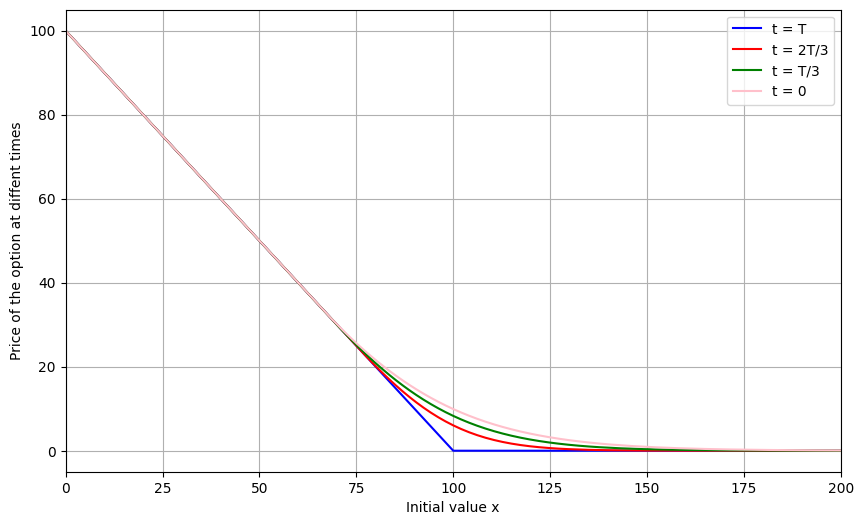

In [519]:
def FDS_american_put(T, r, sigma, K, l_borne, n_time, n_space, theta, scheme_type):
    
    # Space and time parameters
    dt = T / n_time
    dx = (2 * l_borne) / (n_space + 1)
    X = np.linspace(-l_borne, l_borne, n_space+2)
    
    # Matrix A
    alpha = sigma**2 / (2*dx**2) - (r - (sigma**2)/2)/(2*dx)
    beta = -sigma**2/(dx**2) - r
    gamma = sigma**2 / (2*dx**2) + (r - (sigma**2) / 2)/(2*dx)
    A = np.diag([beta] * (n_space + 2))
    for i in range(n_space + 1):
        A[i, i + 1] = gamma
        A[i + 1, i] = alpha
    A[0, 0] = beta + alpha
    A[n_space + 1, n_space + 1] = beta + gamma

    # Matrix of the solution (lignes for the time and columns for the space)
    u = np.zeros(shape=(n_time,n_space + 2))
    u[-1,:] = np.maximum(K - np.exp(X), 0)
    u[-1,0] = u[-1,1]
    u[-1,n_space + 1] = u[-1,n_space]
    
    match scheme_type:
        case 'explicit': # Explicit scheme
            B = np.eye(n_space + 2) + A * dt
            for i in range(n_time - 1, 0, -1):
                u[i-1,:] = np.maximum(B @ u[i,:], u[-1,:])

        case 'implicit': # Implicit scheme
            B_tilde = np.eye(n_space + 2) - A * dt
            for i in tqdm(range(n_time - 1, 0, -1)):
                u[i-1,:] = np.linalg.solve(B_tilde, u[i,:])
                u[i-1,:] = np.maximum(u[i-1,:], u[-1,:])

        case 'theta': # Theta scheme
            B_2 = np.eye(n_space + 2) - theta * A * dt
            B_3 = np.eye(n_space + 2) + (1 - theta) * A * dt
            for i in tqdm(range(n_time - 1, 0, -1)):
                B_4 = B_3 @ u[i, :]
                u[i-1, :] = np.linalg.solve(B_2, B_4)
                u[i-1, :] = np.maximum(u[i-1, :], u[-1,:])
        
        case 'Crank-Nicholson': # Crank-Nicholson scheme
            theta = 1/2
            B_2 = np.eye(n_space + 2) - theta * A * dt
            B_3 = np.eye(n_space + 2) + (1 - theta) * A * dt
            for i in tqdm(range(n_time - 1, 0, -1)):
                B_4 = B_3 @ u[i, :]
                u[i-1, :] = np.linalg.solve(B_2, B_4)
                u[i-1, :] = np.maximum(u[i-1, :], u[-1,:])

    return u, X

# Input parameters
n_space = 1000
n_time = 1000
l_borne = 10
scheme_type = 'implicit' # explicit, implicit, theta, Crank-Nicholson
theta = 1/2

# Model parameters
r, sigma, x, K, T = 0.06, .4, 80, 100, 0.5

# Compute the function
N, X = FDS_american_put(T, r, sigma, K, l_borne, n_time, n_space, theta, scheme_type)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(np.exp(X), N[n_time-1,:], label='t = T', color='blue')
plt.plot(np.exp(X), N[2*n_time//3,:], label='t = 2T/3', color='red')
plt.plot(np.exp(X), N[n_time//3,:], label='t = T/3', color='green')
plt.plot(np.exp(X), N[0,:], label='t = 0', color='pink')
plt.xlim(0, 200)
plt.xlabel('Initial value x')
plt.ylabel('Price of the option at diffent times')
plt.legend()
plt.grid(True)
plt.show()